# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

import OncoMarkAI as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2023-07-19 15:09:31|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

# Copy number variation

In [3]:
focal_cnv = pd.read_csv("../OncoMarkAI/data/datasets/KIR3DL2_alterations_across_samples.tsv", sep="\t")
patient_meta_cBio = pd.read_csv("../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
focal_cnv["TCGA_project"] = focal_cnv["Patient ID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])
focal_cnv["KIR3DL2: AMP"] = focal_cnv["KIR3DL2: AMP"] == "AMP"
focal_cnv["KIR3DL2: HOMEDEL"] = focal_cnv["KIR3DL2: HOMDEL"] == "HOMDEL"
focal_cnv_amp_rate = focal_cnv.groupby("TCGA_project").sum()[["KIR3DL2: AMP"]] / focal_cnv.groupby("TCGA_project").count()[["KIR3DL2: AMP"]]
focal_cnv_del_rate = focal_cnv.groupby("TCGA_project").sum()[["KIR3DL2: HOMEDEL"]] / focal_cnv.groupby("TCGA_project").count()[["KIR3DL2: HOMEDEL"]]

In [4]:
CNV_rate = focal_cnv_amp_rate.join(focal_cnv_del_rate) * 100
CNV_rate = CNV_rate.reindex(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC'])
CNV_rate.columns= ["Amplification", "Deletion"]
CNV_rate = CNV_rate[~CNV_rate.index.isin(["DLBC", "LAML"])]
CNV_rate =  CNV_rate.loc[CNV_rate[["Amplification", "Deletion"]].sum(axis=1).sort_values(ascending=False).index]
CNV_rate.head()

,Amplification,Deletion
TCGA_project,,
LGG,0.194553,3.501946
BLCA,3.163017,0.000000
ESCA,1.098901,1.098901
OV,1.880342,0.000000
BRCA,1.660517,0.092251


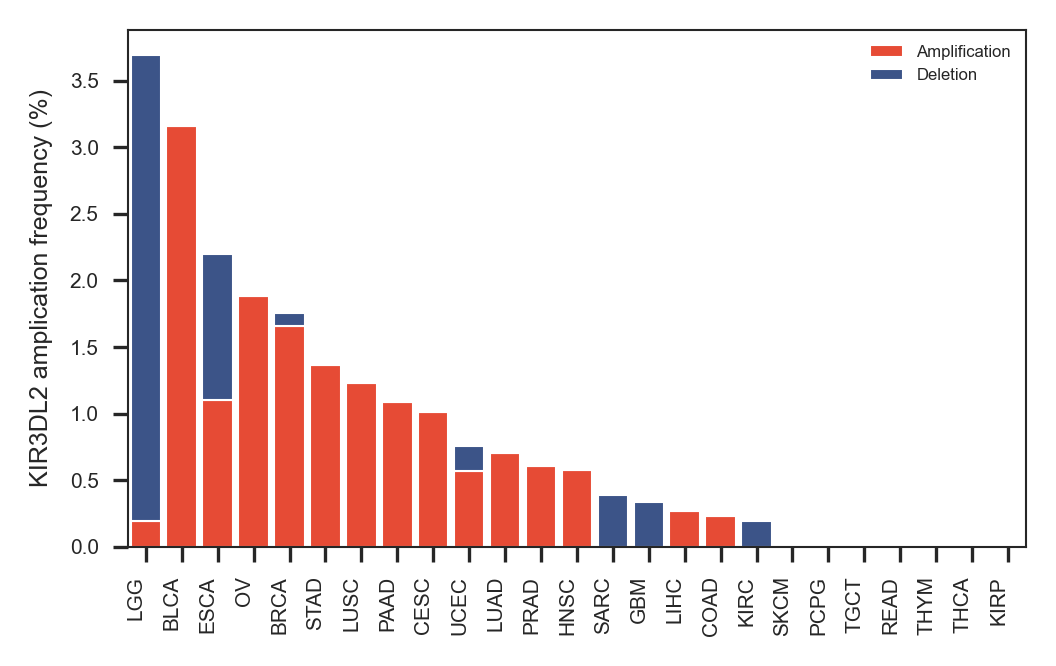

In [5]:
cmap = oma.pl.cmap()
width = .85

fig, ax = plt.subplots(figsize = (3.5, 2.2))
bottom = np.zeros(CNV_rate.shape[0])

for col, color in zip(CNV_rate.columns, [cmap.npg_palette(0), cmap.npg_palette(3)]):
    p = ax.bar(CNV_rate.index, CNV_rate[col], width, label=col, bottom=bottom, color=color, linewidth=.5)
    bottom += CNV_rate[col].values
ax.set_xlim(-0.5, CNV_rate.shape[0]-.5)
ax.set_ylim(0., CNV_rate.sum(axis=1).max()*1.05)
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="", ylabel="KIR3DL2 amplication frequency (%)");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.savefig("../figures/Extended.Fig4g.pdf", bbox_inches = "tight")

# Expression in tumor vs Normal

In [6]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMarkAI/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=100, sample_type="Tumor", genes=["KIR3DL2"])
KIR3DL2_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","subtype", "samples.sample_type"]])

patient_data_TCGA_normal = oma.data.load_tcga(file_path="../OncoMarkAI/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                              metadata="../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                              filter_samples=10, sample_type="Normal", genes=["KIR3DL2"])
KIR3DL2_normal = patient_data_TCGA_normal.to_df().join(patient_data_TCGA_normal.obs[["project_id","subtype", "samples.sample_type"]])

KIR3DL2 = pd.concat([KIR3DL2_tumor, KIR3DL2_normal])
KIR3DL2 = KIR3DL2[~KIR3DL2['project_id'].isin(['LAML', "DLBC"])]

2023-07-19 15:09:33|INFO|dataloader|Dropping duplicates...
2023-07-19 15:09:33|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2023-07-19 15:09:33|INFO|dataloader|Take Tumor samples only.
2023-07-19 15:09:33|INFO|dataloader|Take gene expression data of ['KIR3DL2']
2023-07-19 15:09:33|INFO|dataloader|Filtering out patients with < 100 samples...
2023-07-19 15:09:33|INFO|dataloader|Dropping duplicates...
2023-07-19 15:09:33|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2023-07-19 15:09:33|INFO|dataloader|Take Normal samples only.
2023-07-19 15:09:33|INFO|dataloader|Take gene expression data of ['KIR3DL2']
2023-07-19 15:09:33|INFO|dataloader|Filtering out patients with < 10 samples...


In [7]:
KIR3DL2 = KIR3DL2.query('subtype!="BRCA_Normal"')
KIR3DL2['sample_type'] = KIR3DL2['samples.sample_type'].map({"Solid Tissue Normal": "Normal"}).fillna("Tumor")
KIR3DL2['Xlabel'] = KIR3DL2['project_id'].copy()
KIR3DL2 = KIR3DL2[KIR3DL2['Xlabel'].notna()]
KIR3DL2["Xlabel"] = KIR3DL2["Xlabel"].str.replace("_", "-")
KIR3DL2['xtick'] = [str(v[0]) + "." + str(v[1]) for v in KIR3DL2[["Xlabel", "sample_type"]].values]

In [8]:
results = pd.DataFrame(index=KIR3DL2['Xlabel'].unique(), columns=["tstat", "pval", "median1", "median2", "sample_size1", "sample_size2", "diff_med"])

for pid in KIR3DL2['Xlabel'].unique():
    subset = KIR3DL2.query('Xlabel==@pid')
    tstat_res = oma.tl.t_test(subset, groupby='sample_type', group1='Tumor', group2='Normal', value='KIR3DL2')
    results.loc[pid, "tstat"] = float(tstat_res[0])
    results.loc[pid, "pval"] = float(tstat_res[1])
    results.loc[pid, "median1"] = float(tstat_res[4][0])
    results.loc[pid, "median2"] = float(tstat_res[4][1])
    results.loc[pid, "sample_size1"] = int(tstat_res[5][0])
    results.loc[pid, "sample_size2"] = int(tstat_res[5][1])
    results.loc[pid, "diff_med"] = float(tstat_res[4][0]) - float(tstat_res[4][1])
    
results = results[results.index.notna()]
results = results.drop(index=["KICH"])
results['stars'] = [oma.pl.pval2star(p, keep_pval=False) for p in results['pval']]

/Users/caibin/miniconda3/envs/PathoVision/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/caibin/miniconda3/envs/PathoVision/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
results = results.loc[['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']]

In [10]:
# Convert the column to the Categorical data type with the custom order
KIR3DL2['Xlabel'] = pd.Categorical(KIR3DL2['Xlabel'], categories=results.index.tolist(), ordered=True)
KIR3DL2['sample_type'] = pd.Categorical(KIR3DL2['sample_type'], categories=["Tumor", "Normal"], ordered=True)
# Sort the DataFrame by the custom-ordered column
KIR3DL2 = KIR3DL2.sort_values(["Xlabel", "sample_type"]).dropna()

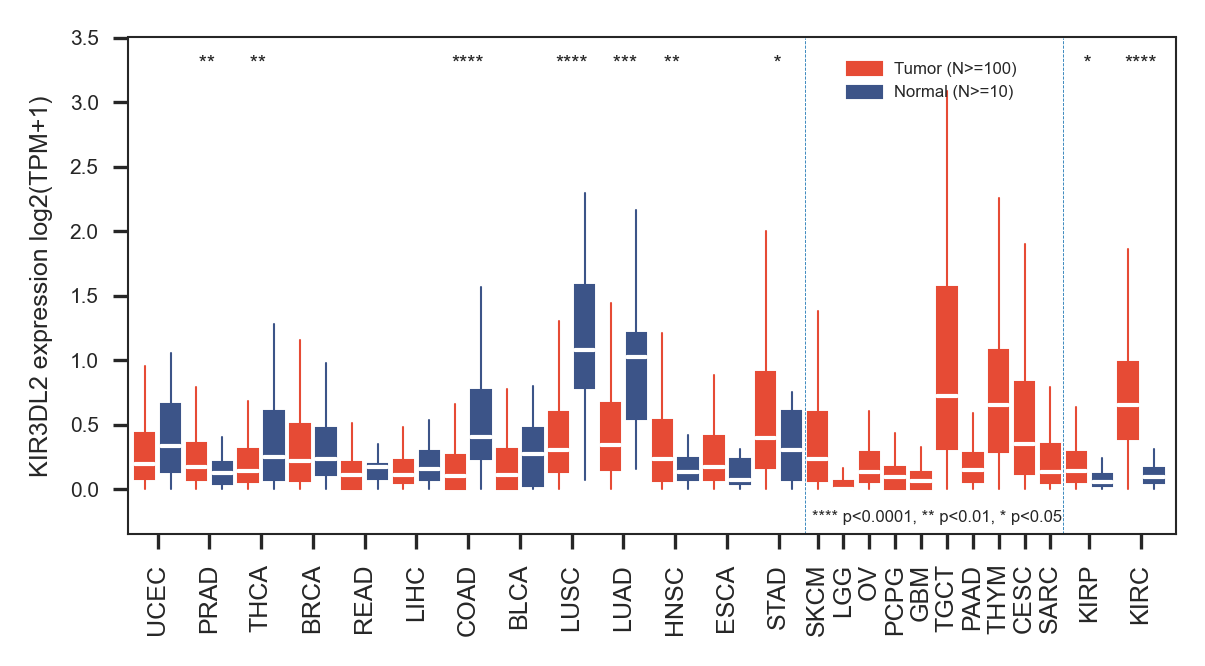

In [11]:
plt.figure(figsize=(4, 2.2))

PROPS = {
    'boxprops':{
        'facecolor':'none',
               },
}
color = [cmap.npg_palette(3) if x.endswith('Normal') else cmap.npg_palette(0) for x in KIR3DL2['xtick'].unique()]

ax = sns.boxplot(data=KIR3DL2, 
                 x='xtick',
                 y='KIR3DL2', 
                 palette=color, 
                 showfliers = False,
                 showcaps=False,
                 saturation=1,
                 dodge=True,
                 width=0.75,
                 # **PROPS
                  );

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.patches.PathPatch:
        c.set_edgecolor(color[i])
        c.set_linewidth(0.5)
        i+=1

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.lines.Line2D:        
        [c.set_linewidth(1.) if i%3==2 else c.set_linewidth(0.5)]
        
        # if i // 3 == 1:
        #     c.set_color('white')
        if i%3==2:
            c.set_color('white')
        else:
            c.set_color(color[i//3])
        i+=1

for i, ticklabel in enumerate(ax.xaxis.get_ticklabels()):
    if ticklabel.get_text().split('.')[1]=='Normal':
        ax.text(ticklabel.get_position()[0]-1.15, 3.25, results.loc[ticklabel.get_text().split(".")[0], 'stars'],  fontsize=5) #color=cmap.Vermilion, rotation='vertical', 
        
xlim = ax.get_xlim()
xticks = [x.split(".")[0] for x in KIR3DL2['xtick'].unique()]
Xtick_tmp = pd.DataFrame([ax.get_xticks(), xticks]).T
Xtick_tmp.columns=['xticks', 'tumor']
Xtick_tmp = Xtick_tmp.groupby('tumor').mean().sort_values('xticks')

ax.set(xlabel='', ylim=(-.35, 3.5), xlim=(-.65, xlim[1]+.35));
ax.set_xticks(Xtick_tmp['xticks'].astype(float).values, labels=Xtick_tmp.index.to_list());
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=6);
ax.set_ylabel('KIR3DL2 expression log2(TPM+1)', fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5);

ax.vlines(25.5, -.35, 3.5, ls='--', lw=0.2)
ax.vlines(35.5, -.35, 3.5, ls='--', lw=0.2)

from matplotlib.patches import Patch
handles = [
    Patch(edgecolor=fc, facecolor=fc, label=label, linewidth=.75) #"white"
    for label, ec, fc in zip(['Tumor (N>=100)', 'Normal (N>=10)'], [cmap.npg_palette(0), cmap.npg_palette(3)], [cmap.npg_palette(0), cmap.npg_palette(3)])
]
ax.legend(handles=handles, loc=(.68, 0.86), ncols=1, fontsize=4., frameon=False);
ax.text(25.8, -.25, '**** p<0.0001, ** p<0.01, * p<0.05', rotation='horizontal', fontsize=4); #*** adj.p<0.001,, style='italic'
plt.savefig("../figures/Extended_Fig4f.pdf")